**InsideAirbnb - Vancouver - Exploratory Data Analysis**

**Descriptions**

- `calendar.csv.gz` -> Detailed Calendar Data for listings in Vancouver
- `reviews.csv.gz` ->	Detailed Review Data for listings in Vancouver
- `listings.csv.gz` ->	Detailed Listings data for Vancouver
- `listings.csv` ->	Summary information and metrics for listings in Vancouver _(good for visualisations)_
- `neighbourhoods.csv` ->	Neighbourhood list for geo filter. Sourced from city or open source GIS files

In [1]:
# Loading the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in source, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

**Importing the required libraries**

In [2]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 40.8 MB/s 
     |████████████████████████████████| 16.7 MB 45.4 MB/s 


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import geopandas as gpd
from datetime import datetime
from pathlib import Path

%matplotlib inline

**Setting the path**

In [4]:
path = "/content/"
os.chdir(path)

**Rows and Columns for each file**

In [5]:
LISTING_FULL_FILE = "listings.csv.gz"
LISTING_LIGHT_FILE = "listings.csv"
CALENDAR_FILE = "calendar.csv.gz"
REVIEWS_FILE = "reviews.csv.gz"
NEIGHBOURHOODS_FILE = "neighbourhoods.csv"

In [6]:
file_list = [LISTING_FULL_FILE, LISTING_LIGHT_FILE, CALENDAR_FILE, REVIEWS_FILE, NEIGHBOURHOODS_FILE]
for f in file_list:
    compression = 'gzip' if f.endswith(".gz") else 'infer'
    df = pd.read_csv(os.path.join(path, f), sep=',', header=0, compression=compression, low_memory=False)
    print("File {} has shape {}".format(f, df.shape))

File listings.csv.gz has shape (5572, 75)
File listings.csv has shape (5572, 18)
File calendar.csv.gz has shape (2033781, 7)
File reviews.csv.gz has shape (218812, 6)
File neighbourhoods.csv has shape (23, 2)


**Observations:**

- Files `listings.csv` and `listings.csv.gz` are consistent in terms of **rows**, just the number of **columns** that changes. As per the files descriptions, the first one is a summary of the second, so _this is expected_.

- `calendar.csv.gz` file is the one that contains the most important number of rows (20 million lines approx!)

- `reviews.csv.gz` file has also a lot of rows, more than two million and a few columns.

- `neighbourhoods.csv` file is very small with only 23 rows, which is not a big surprise as per file description

**Starting off the analysis with `Listings` since `Calendar` and `Reviews` are also related to `Listings`**

In [7]:
df = pd.read_csv(LISTING_LIGHT_FILE, sep=',', header=0)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13358,Monthly (or Longer ) Designer One Bedroom Down...,52116,Lynn,NaN,West End,49.28201,-123.12669,Entire home/apt,100,30,437,2022-07-05,2.94,1,35,7,18-611603
1,13490,Vancouver's best kept secret,52467,Iris,NaN,Kensington-Cedar Cottage,49.25622,-123.06607,Entire home/apt,150,30,94,2022-09-01,0.68,1,204,4,NaN
2,14267,EcoLoft Vancouver,56030,Peter & Alison,NaN,Kensington-Cedar Cottage,49.24922,-123.08139,Entire home/apt,150,3,34,2021-07-14,0.23,1,0,0,21-156500
3,14424,Spacious one-bedroom in sought-after Strathcona,56709,Samantha Jo,NaN,Downtown Eastside,49.27921,-123.08835,Entire home/apt,166,30,261,2022-08-16,1.71,3,185,3,19-162091
4,16254,Close to PNE/Hastings Park Garden level suite,63238,Jason,NaN,Hastings-Sunrise,49.27721,-123.04086,Entire home/apt,350,3,7,2022-07-30,0.14,1,10,2,19-162421


In [8]:
df.shape

(5572, 18)

**Basic Understanding of the Data**

We have **18 features** that describe what is a listing and give information about:

- Who it belongs to (`host_id` and `host_name`)
- Its `name` (or headline for advertisement - some text probably written by the owner) and an `id` (numeric) (probably unique within the Information System)
- Its `location` - some elements about neighbourhood and geographic coordinates `latitude` + `longitude`.
- Its type (`room_type`) - Here, all values are the same so perhaps they come from a defined and finite list
- The `price` (numeric)
- `minimum number of nights` - to stay
- Data about reviews: `number of reviews` for this listing, last time it has been reviewed and a statistic value
- `calculated_host_listings_count` - seems numeric but no real clue so far of what is means
- `availability_365` - the number of days it is available in a whole year
- `license` - weather the owner is licensed or not!


**Data Information Overview**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5572 non-null   int64  
 1   name                            5572 non-null   object 
 2   host_id                         5572 non-null   int64  
 3   host_name                       5572 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   5572 non-null   object 
 6   latitude                        5572 non-null   float64
 7   longitude                       5572 non-null   float64
 8   room_type                       5572 non-null   object 
 9   price                           5572 non-null   int64  
 10  minimum_nights                  5572 non-null   int64  
 11  number_of_reviews               5572 non-null   int64  
 12  last_review                     47

**Observations:**

- There are few missing values in this dataset, only `neighbourhood_group` which has only (or all) missing values (so what is the purpose of providing this column?)
- The other columns which contains missing values are the ones about reviews and license, probably the listings which hasnt recived any reviews (probably new listing) and listings which doesnt have a license.

**Numerical Analysis**

In [10]:
df.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,5.572000e+03,5.572000e+03,0.0,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,4760.000000,5572.000000,5572.000000,5572.000000
mean,1.636484e+17,1.544890e+08,NaN,49.262170,-123.108186,233.403266,16.684314,39.269921,1.883460,4.942570,142.150574,12.597990
std,2.813287e+17,1.516400e+08,NaN,0.022326,0.041181,450.007706,32.676445,72.008985,2.008404,10.559383,126.920090,19.482395
min,1.335800e+04,6.033000e+03,NaN,49.187900,-123.242080,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.469513e+07,2.008364e+07,NaN,49.249920,-123.129760,115.750000,2.000000,2.000000,0.360000,1.000000,24.000000,0.000000
50%,4.315240e+07,9.641140e+07,NaN,49.269110,-123.113872,170.000000,3.000000,12.000000,1.080000,1.000000,102.000000,3.000000
75%,5.462985e+17,2.652491e+08,NaN,49.279050,-123.085393,262.000000,30.000000,46.000000,2.872500,3.000000,257.250000,18.000000
max,7.123038e+17,4.783302e+08,NaN,49.307050,-123.005440,20000.000000,399.000000,1285.000000,19.790000,64.000000,365.000000,215.000000


**Observations & Related Statistics:**

- `price`: mean value is 233 with an impressive max value (20000!)

- `minimum_nights`: the mean is around 16 days (so around two weeks) BUT 50% of the listings have a minimum at 3 so I would say that the "spirit" of the service is still respected, we do not have to rent for one week minimum for instance.

- Each listing got around 39 reviews (mean), some of them have no review (min = 0) which explains why we have seen missing values earlier and max number of reviews a listing has received is 1285 reviews!

- There is high variance in this feature (as per shown also by the standard deviation value). 

**Some Other Facts & Figures**

- `minimum_nights`: the max is around 399 days! Outliers?!

- If my intuition about `calculated_host_listings_count` is right, that would mean that someone has 10 homes/apartments on average to rent in Vancouver. Impressive business!


**Moving on to `Neighbourhoods`**

In [11]:
df.neighbourhood.nunique()

23

**So, 23 different / unique values for the neighbourhood. Probably `Categorical` values!**

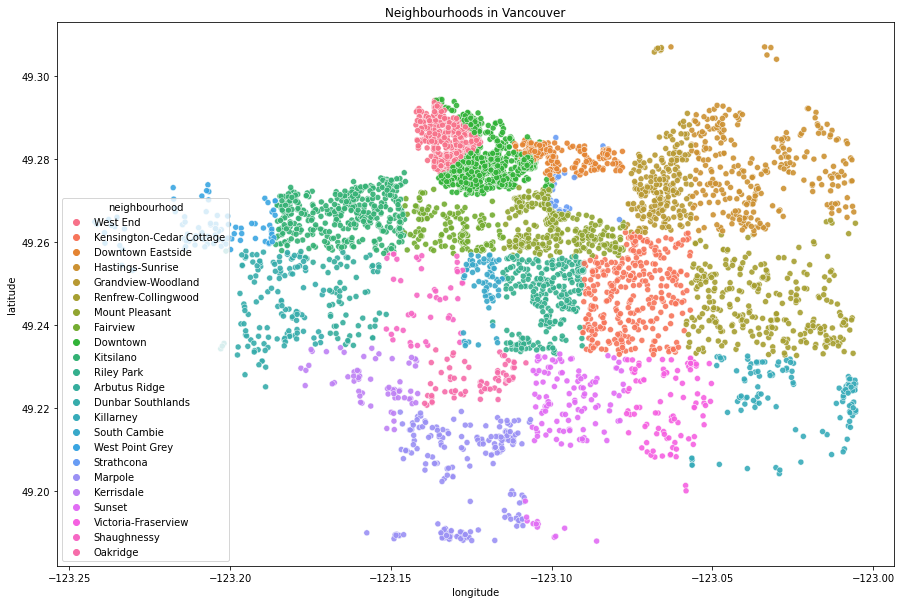

In [12]:
figure, axis = plt.subplots(1, 1, figsize=(15, 10))
axis.set_title("Neighbourhoods in Vancouver")
sns.scatterplot(x="longitude", y="latitude", hue='neighbourhood', data=df, alpha=0.9, palette=None, ax=axis)
plt.show()

**Moving on to `Calendar` Data**

In [13]:
df_cal = pd.read_csv(CALENDAR_FILE, sep=',', header=0)
df_cal.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,654744,2022-09-10,f,$150.00,$150.00,30,1125
1,654744,2022-09-11,f,$150.00,$150.00,30,1125
2,654744,2022-09-12,f,$150.00,$150.00,30,1125
3,654744,2022-09-13,f,$150.00,$150.00,30,1125
4,654744,2022-09-14,f,$150.00,$150.00,30,1125


In [14]:
df_cal.shape

(2033781, 7)

**We have 7 features to describe what is a calendar:**

- `listing_id`: seems to be a reference to listings we have. (Can merge two datasets based on `id`)
- `date`: format is `yyyy-mm-dd` 
- 2 features for the `price` and `adjusted_price`: values are the same for the first rows. Always the case? Note that the currency is USD even if it should be CAD
- `minimum number of nights` and `maximum number of nights to stay`, as already seen previously.
- `price` values are not numeric, needs the symbol to be removed and then converted to numeric

In [15]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033781 entries, 0 to 2033780
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           object
 4   adjusted_price  object
 5   minimum_nights  int64 
 6   maximum_nights  int64 
dtypes: int64(3), object(4)
memory usage: 108.6+ MB


In [16]:
df_cal.isna().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

**Further Analysis**

In [17]:
print("Date range: the dataset contains information from {} to {}".format(df_cal.date.min(), df_cal.date.max()))
print("We have {} different listings in the dataset".format(df_cal.listing_id.nunique()))

Date range: the dataset contains information from 2022-09-10 to 2023-09-10
We have 5572 different listings in the dataset


In [18]:
df_price_diff = df_cal[df_cal['price'] != df_cal['adjusted_price']]
print("{} rows have different values for 'price' and 'adjusted_price'".format(df_price_diff.shape[0]))

43818 rows have different values for 'price' and 'adjusted_price'


In [19]:
df_price_diff.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
14600,2764812,2022-09-10,f,$560.00,$521.00,2,1125
14601,2764812,2022-09-11,f,$560.00,$521.00,3,1125
14602,2764812,2022-09-12,f,$560.00,$521.00,3,1125
14603,2764812,2022-09-13,f,$560.00,$521.00,3,1125
14604,2764812,2022-09-14,f,$560.00,$521.00,3,1125


***A Discount might be a possible explanation for the price difference***

- 7% discount on 560 gives 521 approx!!

In [20]:
df_cal.available.value_counts()

f    1241298
t     792483
Name: available, dtype: int64

**Stands for 'False'/'True'. This will be easily transformed as binary column 0/1**

In [21]:
df_cal.describe()

,listing_id,minimum_nights,maximum_nights
count,2.033781e+06,2.033781e+06,2.033781e+06
mean,1.636483e+17,1.767975e+01,1.539243e+06
std,2.813034e+17,3.684297e+01,5.745818e+07
min,1.335800e+04,1.000000e+00,1.000000e+00
25%,2.470314e+07,2.000000e+00,3.650000e+02
50%,4.315034e+07,3.000000e+00,1.125000e+03
75%,5.462622e+17,3.000000e+01,1.125000e+03
max,7.123038e+17,3.990000e+02,2.147484e+09


- `Availability` is missing because it is categorical (f/t) and not numerical (0/1)
- `price` missing because not numeric - removed currency symbol
- `Maximum` and `Minimum` nights - values are crazy! 

**Review Files**

In [22]:
df_reviews = pd.read_csv(REVIEWS_FILE, sep=',', header=0)
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,13358,56256,2010-06-22,142680,Eurassia,"Stunning apartment, absolutely gorgeous interi..."
1,13358,60340,2010-07-03,141138,Christine,"Very nice flat in the city center, walking dis..."
2,13358,61832,2010-07-06,151075,Alina,My husband and I stayed at Linda's apartment f...
3,13358,66070,2010-07-18,157548,Eric,This cozy and stylish suite has an ideal locat...
4,13358,82509,2010-08-22,153300,Rhona,I had an amazing (almost) 2wks at the apartmen...


In [23]:
df_reviews.shape

(218812, 6)

In [24]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218812 entries, 0 to 218811
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     218812 non-null  int64 
 1   id             218812 non-null  int64 
 2   date           218812 non-null  object
 3   reviewer_id    218812 non-null  int64 
 4   reviewer_name  218811 non-null  object
 5   comments       218780 non-null  object
dtypes: int64(3), object(3)
memory usage: 10.0+ MB


In [25]:
df_reviews.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     1
comments         32
dtype: int64

**Neighbourhoods File**

In [26]:
df_neigh = pd.read_csv(NEIGHBOURHOODS_FILE, sep=',', header=0)
df_neigh.head()

,neighbourhood_group,neighbourhood
0,NaN,Arbutus Ridge
1,NaN,Downtown
2,NaN,Downtown Eastside
3,NaN,Dunbar Southlands
4,NaN,Fairview


In [27]:
df_neigh.head(20)

,neighbourhood_group,neighbourhood
0,NaN,Arbutus Ridge
1,NaN,Downtown
2,NaN,Downtown Eastside
3,NaN,Dunbar Southlands
4,NaN,Fairview
5,NaN,Grandview-Woodland
6,NaN,Hastings-Sunrise
7,NaN,Kensington-Cedar Cottage
8,NaN,Kerrisdale
9,NaN,Killarney


This dataset is actually the whole list of neighbourhoods. One column if full of NaN so it will be totally useless for us.



**Full Listing File: Listing Details Analysis -> listing.csv.gz**

In [28]:
df_lst_full = pd.read_csv(LISTING_FULL_FILE, sep=',', header=0, low_memory=False)
df_lst_full.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13358,https://www.airbnb.com/rooms/13358,20220910194347,2022-09-11,city scrape,Monthly (or Longer ) Designer One Bedroom Down...,<b>The space</b><br />This suites central loca...,NaN,https://a0.muscache.com/pictures/40034c18-0837...,52116,...,4.79,4.92,4.67,18-611603,f,1,1,0,0,2.94
1,13490,https://www.airbnb.com/rooms/13490,20220910194347,2022-09-10,city scrape,Vancouver's best kept secret,This apartment rents for one month blocks of t...,"In the heart of Vancouver, this apartment has ...",https://a0.muscache.com/pictures/73394727/79d5...,52467,...,4.97,4.77,4.88,NaN,f,1,1,0,0,0.68
2,14267,https://www.airbnb.com/rooms/14267,20220910194347,2022-09-10,previous scrape,EcoLoft Vancouver,"The Ecoloft is located in the lovely, family r...",We live in the centre of the city of Vancouver...,https://a0.muscache.com/pictures/3646de9b-934e...,56030,...,4.68,4.77,4.71,21-156500,t,1,1,0,0,0.23
3,14424,https://www.airbnb.com/rooms/14424,20220910194347,2022-09-10,city scrape,Spacious one-bedroom in sought-after Strathcona,<b>The space</b><br />Welcome to Strathcona --...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,56709,...,4.72,4.60,4.73,19-162091,f,3,3,0,0,1.71
4,16254,https://www.airbnb.com/rooms/16254,20220910194347,2022-09-11,city scrape,Close to PNE/Hastings Park Garden level suite,2 Bedroom garden level guest suite.(lower leve...,"Good Eats, Cute Shops and all the personality ...",https://a0.muscache.com/pictures/d0cdc9b4-5937...,63238,...,5.00,4.86,4.29,19-162421,t,1,1,0,0,0.14


In [29]:
df_lst_full.shape

(5572, 75)

In [30]:
df_lst_full.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

**Dropping Non-Useful Columns**

In [31]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df_lst_full = df_lst_full.drop(cols_to_drop, axis=1)

**NULL Values**

In [32]:
df_lst_full.isna().sum()

id                                                 0
source                                             0
host_since                                         0
host_response_time                               984
host_response_rate                               984
host_acceptance_rate                             812
host_is_superhost                                  1
host_listings_count                                0
host_total_listings_count                          0
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood                                   1828
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                    5572
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                  

In [33]:
df_lst_full.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'license'], axis=1, inplace=True)
# The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one
df_lst_full.set_index('id', inplace=True) 

In [34]:
df_lst_full.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [35]:
sum((df_lst_full.minimum_nights == df_lst_full.minimum_minimum_nights) == False)

465

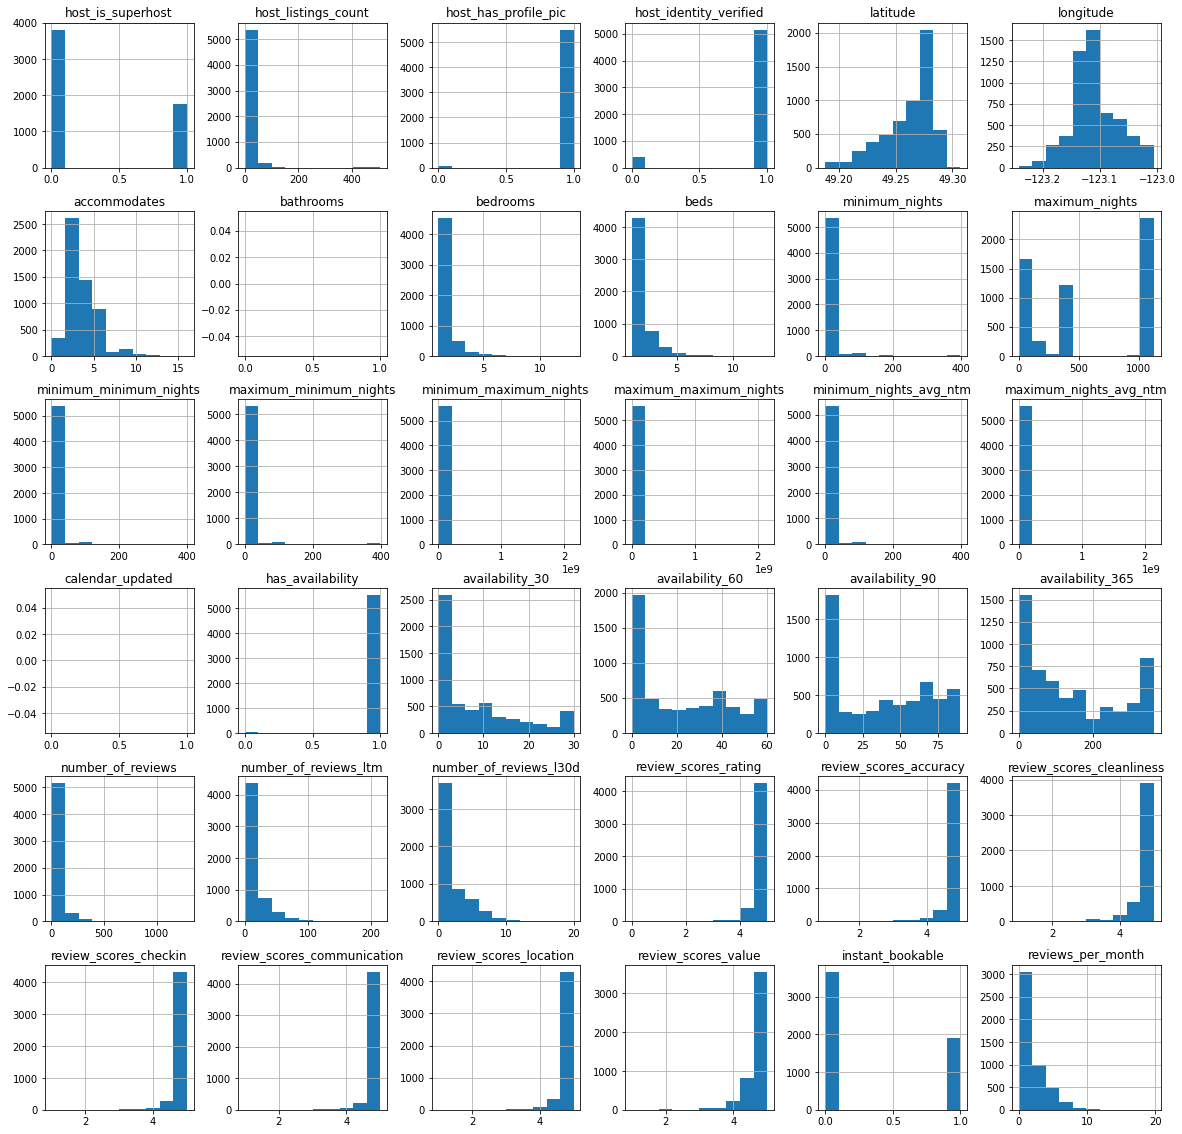

In [36]:
# Replacing columns with f/t with 0/1
df_lst_full.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df_lst_full.hist(figsize=(20,20));

**Host Since**

In [37]:
# Converting to datetime
df_lst_full.host_since = pd.to_datetime(df_lst_full.host_since) 

# Calculating the number of days
df_lst_full['host_days_active'] = (datetime(2019, 4, 9) - df_lst_full.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df_lst_full['host_days_active'].mean(),0))
print("Median days as host:", df_lst_full['host_days_active'].median())

# Replacing null values with the median
df_lst_full.host_days_active.fillna(df_lst_full.host_days_active.median(), inplace=True)

Mean days as host: 838.0
Median days as host: 927.0


**Host Response Time**

In [38]:
print("Null values:", df_lst_full.host_response_time.isna().sum())
print(f"Proportion: {round((df_lst_full.host_response_time.isna().sum()/len(df_lst_full))*100, 1)}%")

Null values: 984
Proportion: 17.7%


In [39]:
df_lst_full.host_response_time.fillna("unknown", inplace=True)
df_lst_full.host_response_time.value_counts(normalize=True)

within an hour        0.605348
unknown               0.176597
within a few hours    0.151831
within a day          0.054200
a few days or more    0.012024
Name: host_response_time, dtype: float64

In [40]:
df_lst_full.host_response_time.value_counts(normalize=True)

within an hour        0.605348
unknown               0.176597
within a few hours    0.151831
within a day          0.054200
a few days or more    0.012024
Name: host_response_time, dtype: float64

**Host Response Rate**

In [41]:
print("Null values:", df_lst_full.host_response_rate.isna().sum())
print(f"Proportion: {round((df_lst_full.host_response_rate.isna().sum()/len(df_lst_full))*100, 1)}%")

Null values: 984
Proportion: 17.7%


In [42]:
# Removing the % sign from the host_response_rate string and converting to an integer
df_lst_full.host_response_rate = df_lst_full.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df_lst_full['host_response_rate'].mean(),0))
print("Median host response rate:", df_lst_full['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df_lst_full.host_response_rate == 100.0).sum()/df_lst_full.host_response_rate.count())*100,1)}%")

Mean host response rate: 96.0
Median host response rate: 100.0
Proportion of 100% host response rates: 82.6%


In [43]:
# Bin into four categories
df_lst_full.host_response_rate = pd.cut(df_lst_full.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df_lst_full.host_response_rate = df_lst_full.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df_lst_full.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df_lst_full.host_response_rate.value_counts()

100%       3789
unknown     984
50-89%      399
90-99%      304
0-49%        96
Name: host_response_rate, dtype: int64

**Property Type**

In [44]:
df_lst_full.property_type.value_counts()

Entire condo                          1460
Entire rental unit                    1005
Entire home                            869
Entire guest suite                     707
Private room in home                   608
Entire loft                            138
Private room in rental unit            122
Entire townhouse                       115
Private room in condo                   96
Entire guesthouse                       78
Entire serviced apartment               71
Private room in guest suite             41
Private room in villa                   36
Room in boutique hotel                  31
Private room in townhouse               26
Entire villa                            21
Entire bungalow                         12
Private room in bed and breakfast       11
Boat                                    11
Room in aparthotel                      10
Private room in guesthouse              10
Entire vacation home                     9
Entire place                             8
Shared room

**Bedrooms, Bathrooms and Beds**

In [45]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df_lst_full[col].fillna(df_lst_full[col].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


**First Review and Last Review**

In [46]:
print(f"Null values in 'first_review': {round(100*df_lst_full.first_review.isna().sum()/len(df_lst_full),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df_lst_full.review_scores_rating .isna().sum()/len(df_lst_full),1)}%")

Null values in 'first_review': 14.6%
Null values in 'review_scores_rating': 14.6%


In [47]:
# Converting to datetime
df_lst_full.first_review = pd.to_datetime(df_lst_full.first_review) 

# Calculating the number of days between the first review and the date the data was scraped
df_lst_full['time_since_first_review'] = (datetime(2019, 4, 9) - df_lst_full.first_review).astype('timedelta64[D]')

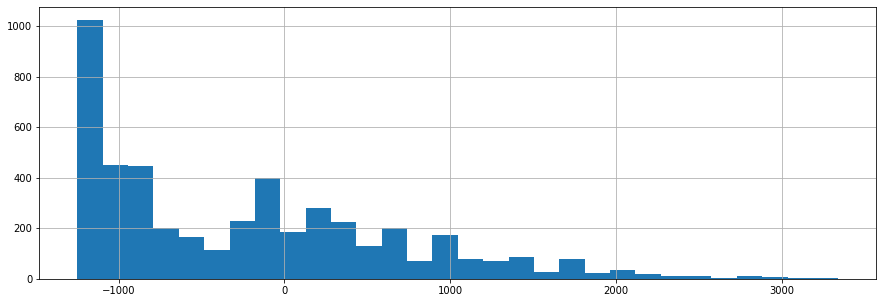

In [48]:
# Distribution of the number of days since first review
df_lst_full.time_since_first_review.hist(figsize=(15,5), bins=30);

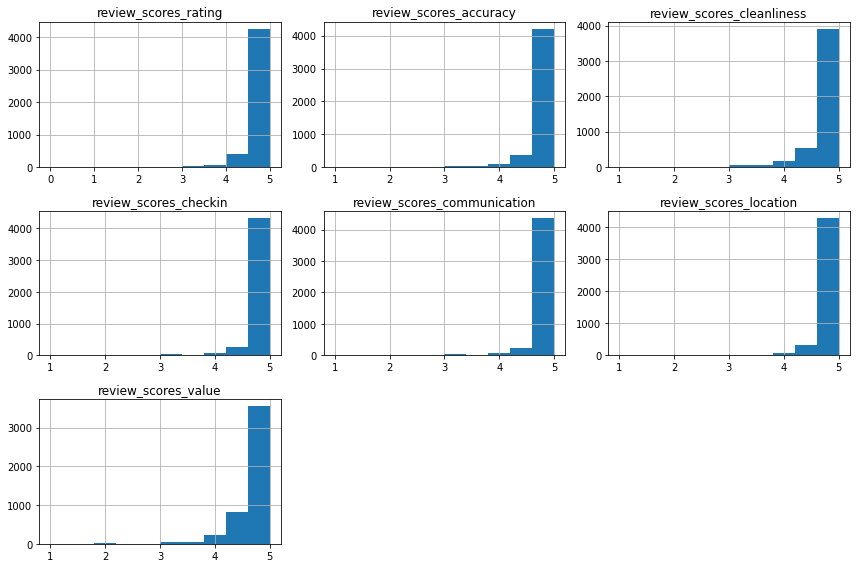

In [49]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df_lst_full.columns[df_lst_full.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df_lst_full[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

**Price**

In [50]:
df_lst_full.price = df_lst_full.price.str[1:-3]
df_lst_full.price = df_lst_full.price.str.replace(",", "")
df_lst_full.price = df_lst_full.price.astype('int64')

**Time Series Data Analysis**

In [51]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df_lst_full.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df_lst_full.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 05 January 2009, and the most recent joined on 05 September 2022.


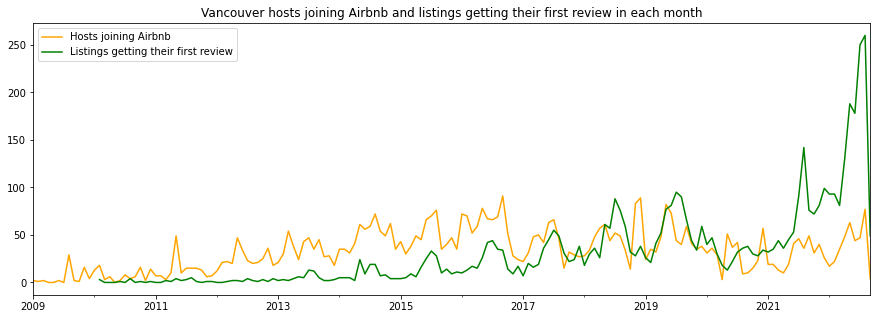

In [52]:
plt.figure(figsize=(15,5))
df_lst_full.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df_lst_full.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Vancouver hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.show()

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [54]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df_lst_full.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df_lst_full.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [55]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

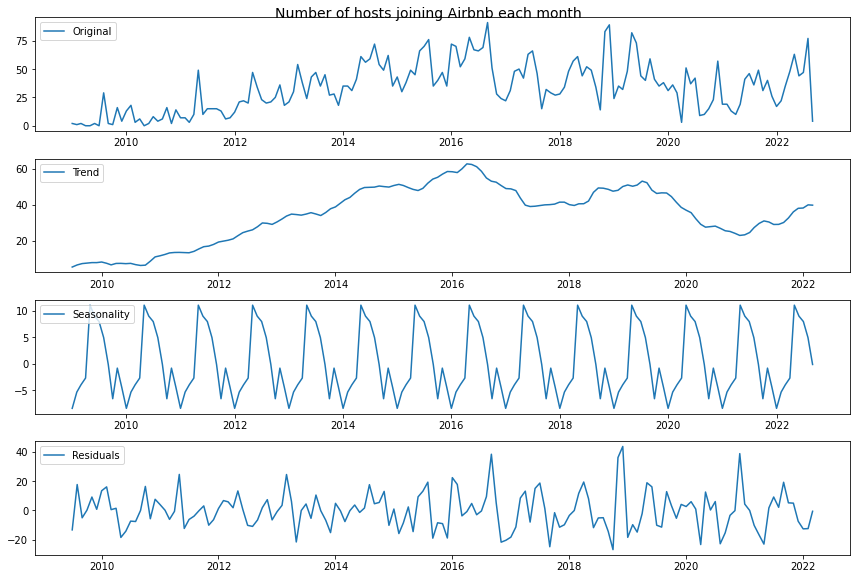

In [56]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

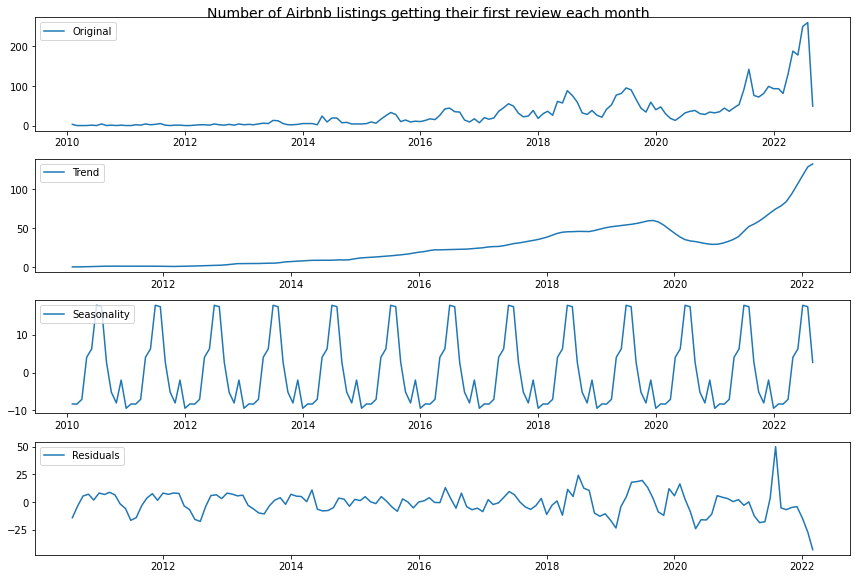

In [57]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


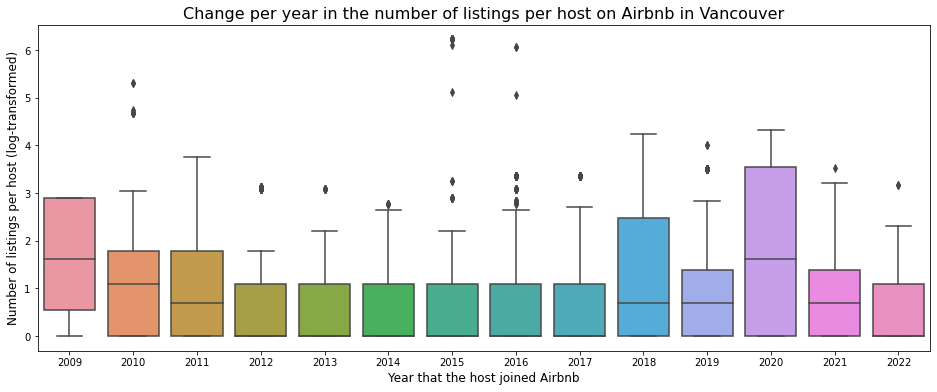

In [58]:
plt.figure(figsize=(16,6))
sns.boxplot(df_lst_full.host_since.dt.year, np.log(df_lst_full.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Vancouver', fontsize=16)
plt.show()

In [59]:
print("Average number of listings per host per year on Airbnb in Vancouver:")
print(round(df_lst_full.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Vancouver:
host_since
2009-01-01     9.37
2010-01-01    19.30
2011-01-01    11.20
2012-01-01     4.46
2013-01-01     2.41
2014-01-01     2.74
2015-01-01    17.54
2016-01-01     5.72
2017-01-01     4.07
2018-01-01    16.31
2019-01-01     4.83
2020-01-01    18.22
2021-01-01     3.33
2022-01-01     2.46
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [60]:
# List of the largest host_listings_count and the year the host joined Airbnb
df_lst_full.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
663711301400410804,2018-11-26,70
629739194988143658,2020-05-17,76
26957873,2010-12-13,108
4118193,2010-02-24,114
21411021,2016-05-06,156
51369107,2015-01-24,166
51694363,2010-04-04,204
44123986,2016-10-21,427
46013112,2015-02-01,449


**Numerical Data Analysis**

In [61]:
df_lst_full.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,host_days_active,time_since_first_review
count,5571.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,0.0,5572.000000,5572.000000,...,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,5572.000000,4760.000000,5572.000000,4760.000000
mean,0.315742,8.038406,0.988873,0.926059,49.262170,-123.108186,3.487437,NaN,1.586145,1.908471,...,4.810552,4.757273,4.854359,4.861140,4.836677,4.675428,0.343324,1.883460,837.952082,-229.936134
std,0.464853,31.866024,0.104906,0.261699,0.022326,0.041181,1.946701,NaN,0.891497,1.137261,...,0.351209,0.387906,0.289836,0.313024,0.249215,0.377624,0.474861,2.008404,1150.889551,910.870082
min,0.000000,1.000000,0.000000,0.000000,49.187900,-123.242080,0.000000,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.010000,-1245.000000,-1249.000000
25%,0.000000,1.000000,1.000000,1.000000,49.249920,-123.129760,2.000000,NaN,1.000000,1.000000,...,4.780000,4.682500,4.830000,4.850000,4.780000,4.590000,0.000000,0.360000,-51.000000,-1041.000000
50%,0.000000,2.000000,1.000000,1.000000,49.269110,-123.113872,3.000000,NaN,1.000000,2.000000,...,4.910000,4.880000,4.950000,4.960000,4.910000,4.760000,0.000000,1.080000,927.000000,-357.000000
75%,1.000000,4.000000,1.000000,1.000000,49.279050,-123.085393,4.000000,NaN,2.000000,2.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,4.880000,1.000000,2.872500,1687.250000,319.000000
max,1.000000,504.000000,1.000000,1.000000,49.307050,-123.005440,16.000000,NaN,13.000000,13.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,19.790000,3746.000000,3340.000000


In [62]:
print(f"Prices range from {min(df.price)} to {max(df.price)}.")

Prices range from 0 to 20000.


**Host Listings Count**

In [63]:
print("Median number of listings per host:", int(df_lst_full.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df_lst_full.host_listings_count.mean())))
print(f"{int(round(100*len(df_lst_full[df_lst_full.host_listings_count == 1])/len(df_lst_full)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 8
49% of listings are from hosts with one listing.


**Accomodation**

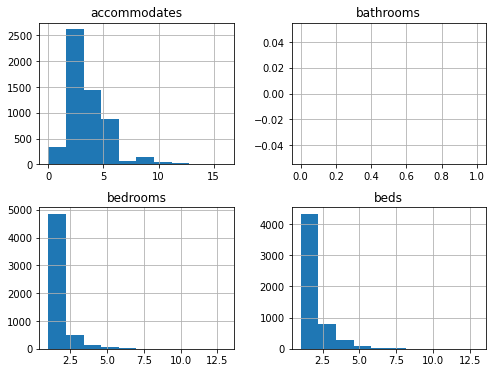

In [64]:
df_lst_full[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

**Categorical Features Analysis**

In [65]:
map_df = gpd.read_file('/content/neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Dunbar Southlands,None,"MULTIPOLYGON (((-123.17909 49.21708, -123.1791..."
1,Renfrew-Collingwood,None,"MULTIPOLYGON (((-123.05888 49.23286, -123.0588..."
2,Hastings-Sunrise,None,"MULTIPOLYGON (((-123.05660 49.26215, -123.0566..."
3,Oakridge,None,"MULTIPOLYGON (((-123.14015 49.21935, -123.1401..."
4,Downtown Eastside,None,"MULTIPOLYGON (((-123.09988 49.27604, -123.1022..."


In [66]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
temp_df = pd.DataFrame(df_lst_full.groupby('neighbourhood_cleansed').size())
temp_df.rename(columns={0: 'number_of_listings'}, inplace=True)
temp_df['median_price'] = df_lst_full.groupby('neighbourhood_cleansed').price.median().values

# Joining the dataframes
temp_df = map_df.set_index('neighbourhood').join(temp_df)

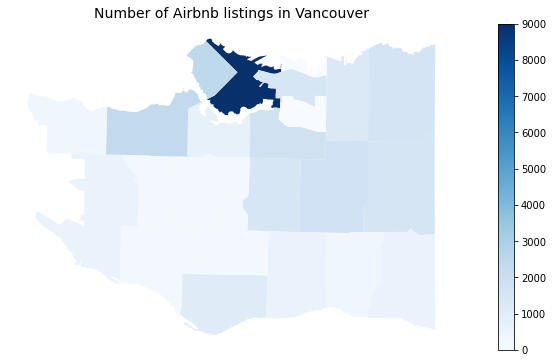

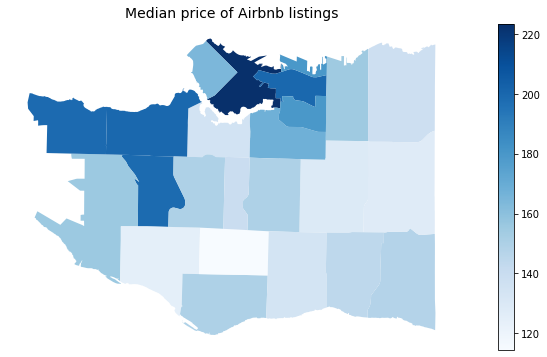

In [67]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
temp_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in Vancouver', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
temp_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(temp_df.median_price), vmax=max(temp_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [68]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df_lst_full.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df_lst_full.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price')
    ax2.set_xlabel('')
    
    plt.show()

**Superhosts**

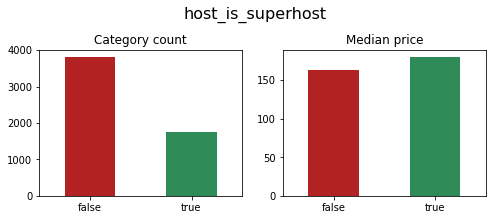

0.0    0.684258
1.0    0.315742
Name: host_is_superhost, dtype: float64


In [69]:
binary_count_and_price_plot('host_is_superhost')
print(df_lst_full.host_is_superhost.value_counts(normalize=True))

**Host Verification**

In [70]:
df_lst_full.host_identity_verified.value_counts(normalize=True)

1    0.926059
0    0.073941
Name: host_identity_verified, dtype: float64

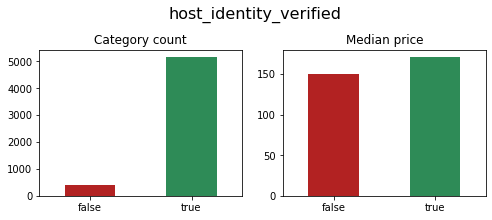

In [71]:
binary_count_and_price_plot('host_identity_verified')